# Template for Resonant Metasurface Characterization

## Initialization

In [1]:
# The only import statement you need, because all the packages are imported in tidy3dHelper.py
from tidy3dHelper import *

In [2]:
# This function gives the tidy3D simulation steps
help()

                TIDY3D SIMULATION STEPS            
>>> INITIALIZATION <<<
0. Define wavelength or frequency range [sim_params = define_simulation_parameters(wvl_min=, wvl_max=, Nfreq=, Mesh=32, run_factor=200)]
1. Define computational domain size
2. Define grid specifications (discretization size)
3. Define structures (geometry, materials, etc.)
4. Define sources (plane wave, Gaussian beam, etc.)
5. Define monitors (fields, flux, etc.)
6. Set simulation run time
7. Specify boundary conditions

>>> SIMULATION <<<
• Assign simulation object (loop or single instance)
• Run simulation (locally or via cloud)

>>> FINALIZATION <<<
• Retrieve results
• Perform postprocessing (e.g., transmission, phase, efficiency)
• Save data to JSON/HDF5/plots

               END OF SIMULATION STEPS             


In [3]:
# This should be the first line of any simulation, which is to define all the basic simulation parameters
lam1=1.52
lam2=1.54
sim_params = define_simulation_parameters(wvl_min=lam1, wvl_max=lam2, Nfreq=101, Mesh=32, run_factor=150)

                     BASIC SIMULATION SETUP                      
[wvls] Wavelength array                 : 1.5400 µm to 1.5200 µm
[freqs] Frequency array                 : 1.9467e+14 Hz to 1.9723e+14 Hz
[Nfreq] Number of points                : 101
[freq0] Central Frequency               : 1.959512e+14 Hz
[fmin]  Minimum Frequency               : 1.946704e+14 Hz
[fmax]  Maximum Frequency               : 1.972319e+14 Hz
[freqw] Bandwidth                       : 2.561453e+12 Hz
[lda0]  Central λ                       : 1.529935e+00 m
[Mesh]  Mesh cells per λ                : 32
[run_time] Simulation run time          : 5.856051e-11 s



## Structures and Materials

Output()

15:53:06 EDT WARNING: Unable to fit with weighted RMS error under               
             'tolerance_rms' of 1e-05                                           

Fit RMS error: 0.07986542949190208


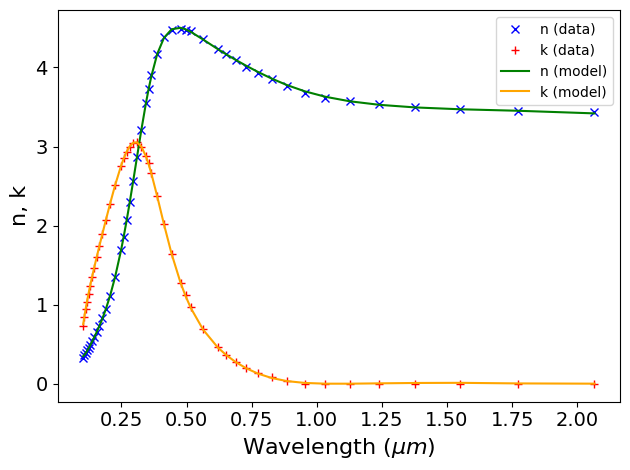

In [4]:
# ============================================================
#                     MATERIALS                    
# ============================================================

#---------------------------<< Substrate Material >>------------------------------------
n_SiO2 = 1.45 # Refractive index
SiO2 = td.Medium(permittivity=n_SiO2**2)

#---------------------------<< Superstrate Material >>------------------------------------
n_sup = 1.0 # Refractive index
Air = td.Medium(permittivity=n_sup**2)

#---------------------------<< Metaatom Material >>------------------------------------
# fitting refractive index data to get a dispersive medium  
url = "https://refractiveindex.info/tmp/database/data-nk/main/Si/Pierce.txt"
fitter = FastDispersionFitter.from_url(url, delimiter="\t")
silicon, error = fitter.fit(max_num_poles=5, tolerance_rms=1e-5)
print("Fit RMS error:", error)
ax = fitter.plot(silicon)
ax.set_title(ax.get_title(), fontsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
ax.tick_params(axis='both', labelsize=14)
plt.show()

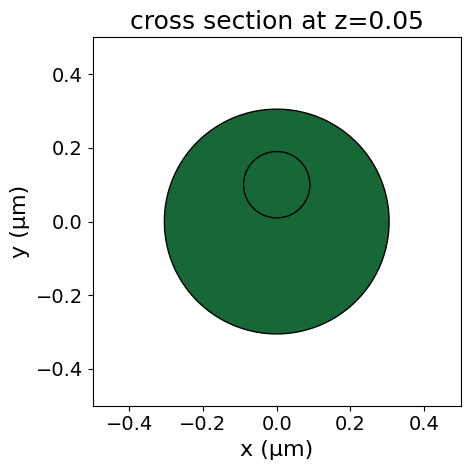

In [5]:
# ============================================================
#                    STRUCTURES                 
# ============================================================

#---------------------------<< Substrate Structure >>------------------------------------
inf_eff = 1e2
substrate = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)),
    medium=SiO2,
)

#---------------------------<< Superstrate Structure >>------------------------------------
# By default, the superstrate is air and infinite, so no need to define it here



#---------------------------<< Metaatom Structure >>------------------------------------
h = 0.1                 # Height of the Meta-Atom
R = 0.305               # Main Radius          
rh = 0.09               # Hole Radius               
delta=0.1               # Off-Center Hole              
px = py = 1             # Meta-Atom Periodicity              
alpha = np.deg2rad(0)   # Meta-Atom Rotation
x0_1, y0_1 = 0, 0       # Si Main Cylinder Location
x0_2, y0_2 = 0, delta   # Off-Center Air Hole Location
n = 500                 # Number of Points

def Meta_atom(x0, y0, Rs, n):
    vertices = []
    dtheta = 2.0 * np.pi / n
    for i in range(n):
        theta = i * dtheta
        Xp = (Rs) * np.cos(theta)
        Yp = (Rs) * np.sin(theta)
        x = x0 + Xp
        y = y0 + Yp
        vertices.append((x, y))
    return vertices

nanodisk_1 = td.Structure(
    geometry=td.PolySlab(
        vertices=Meta_atom(x0_1, y0_1, R, n), axis=2, slab_bounds=(0, h)
    ),
    medium=silicon,
)

nanodisk_2 = td.Structure(
    geometry=td.PolySlab(
        vertices=Meta_atom(x0_2, y0_2, rh, n), axis=2, slab_bounds=(0, h)
    ),
    medium=Air,
)

# Plot the Meta Atom shape 
ax = nanodisk_1.plot(z=0.5*h)
nanodisk_2.plot(z=0.5*h, ax=ax)
ax.set_xlim(-px / 2, px / 2)
ax.set_ylim(-py / 2, py / 2)
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
ax.set_aspect("equal", adjustable="box")
ax.set_title(ax.get_title(), fontsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
ax.tick_params(axis='both', labelsize=14)
plt.show()



## Infinite Structure

In [6]:
# Choosing the Wavelength
lambda_sel_um = 1.5325
idx = int(np.argmin(np.abs(sim_params["wvls"] - lambda_sel_um)))
lambda_used_um = float(sim_params["wvls"][idx])
f_sel = float(sim_params["freqs"][idx])
print(f"Plotting field at λ ≈ {lambda_used_um:.4f} µm  (f ≈ {f_sel/1e12:.3f} THz)")


Plotting field at λ ≈ 1.5325 µm  (f ≈ 195.618 THz)


In [7]:
# Source
source = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=f_sel, fwidth=sim_params["freqw"]),
    size=(td.inf, td.inf, 0),
    center=(0, 0, lambda_used_um),
    direction="-",
    pol_angle=0,
)

# Monitors and Simulation Size
Lz = 3*lam2 # simulation domain size in z
sim_size = [px, py, Lz]
monitor_z =Lz/2.5 # Monitor z position

# Define Transmission Flux Monitor
T_Monitor = td.FluxMonitor(
    center=[0, 0, -monitor_z], size=[td.inf, td.inf, 0], freqs=sim_params["freqs"], name="T"
)
# Define Reflection Flux Monitor: Can be Changed 
R_Monitor = td.FluxMonitor(
    center=[0, 0, monitor_z], size=[td.inf, td.inf, 0], freqs=sim_params["freqs"], name="R"
)   

# define a field monitor to visualize the field distribution under gaussian beam excitation
monitor_field = td.FieldMonitor(
    center=[0, 0, h/2], size=[td.inf, td.inf, 0], freqs=[f_sel], name="field"
)

In [8]:
# Grid Resolution
dl = px / 32
horizontal_grid = td.UniformGrid(dl=dl)
vertical_grid = td.AutoGrid(min_steps_per_wvl=32)
grid_spec=td.GridSpec(
    grid_x=horizontal_grid,
    grid_y=horizontal_grid,
    grid_z=vertical_grid,
)

# Boundary Conditions
bc = td.BoundarySpec(
    x=td.Boundary.periodic(), 
    y=td.Boundary.periodic(), 
    z=td.Boundary.pml()
)

sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, nanodisk_1, nanodisk_2],
    sources=[source],
    monitors=[T_Monitor,R_Monitor,monitor_field],
    run_time=sim_params["run_time"],
    boundary_spec=bc
)

In [9]:
sim.plot_3d()

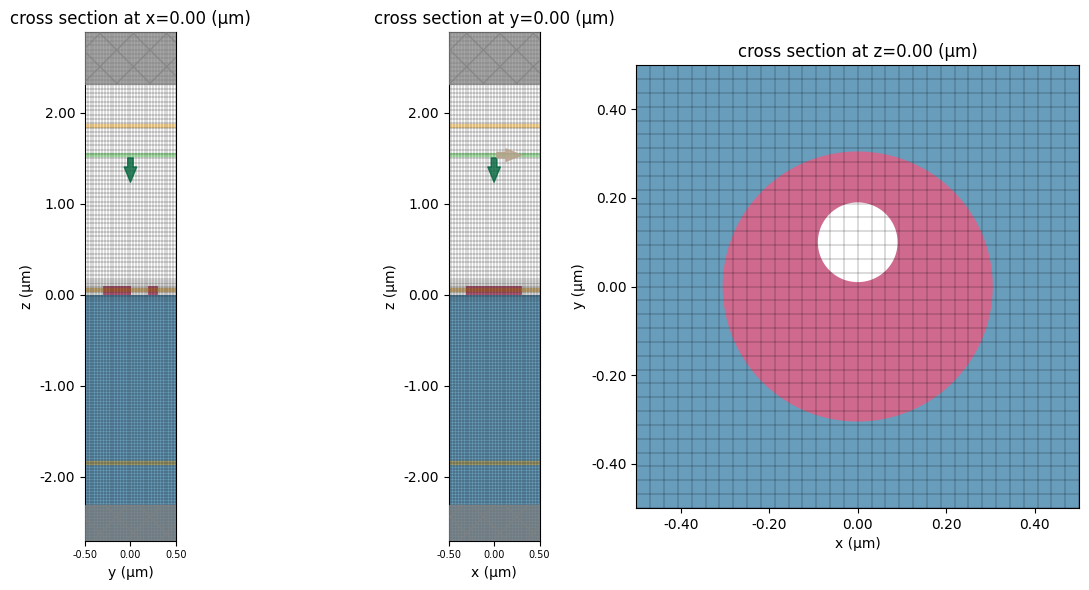

In [10]:
plot_sim(sim, save_as="infinite_structure.png")

In [11]:
# sim_infinite = web.run(
#     sim,
#     task_name="Infinite_Metasurface",
#     path="data/Infinite_Metasurface.hdf5",
#     verbose=True,
# )

15:53:20 EDT WARNING: Simulation has 1.63e+06 time steps. The 'run_time' may be 
             unnecessarily large, unless there are very long-lived resonances.  

             Created task 'Infinite_Metasurface' with task_id                   
             'fdve-080c586a-49c7-48f8-87f3-5503d3353579' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=575695;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080c586a-49c7-48f8-87f3-5503d3353579\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=202893;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080c586a-49c7-48f8-87f3-5503d3353579\taskId]8;;\]8;id=575695;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080c586a-49c7-48f8-87f3-5503d3353579\=]8;;\]8;id=363465;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080c586a-49c7-48f8-87f3-5503d3353579\fdve]8;;\]8;id=575695;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080c586a-49c7-48f8-87f3-5503d3353579\-080c586a-49c]8;;\
             ]8;id=575695;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080c586a-49c7-48f8-87f3-5503d3353579\7-48f8-87f3-5503d3353579']8;;\.

             Task folder: ]8;id=381406;https://tidy3d.simulation.cloud/folders/folder-4a96f49a-40a0-4d85-a7de-71d7af0d2c31\'default']8;;\.

Output()

15:53:21 EDT Maximum FlexCredit cost: 0.092. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

15:53:22 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

15:53:26 EDT status = preprocess

15:53:31 EDT starting up solver

             running solver

Output()

15:53:37 EDT early shutoff detected at 4%, exiting.

             status = postprocess

Output()

15:53:40 EDT status = success

15:53:42 EDT View simulation result at                                          
             ]8;id=182029;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080c586a-49c7-48f8-87f3-5503d3353579\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=12886;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080c586a-49c7-48f8-87f3-5503d3353579\taskId]8;;\]8;id=182029;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080c586a-49c7-48f8-87f3-5503d3353579\=]8;;\]8;id=106334;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080c586a-49c7-48f8-87f3-5503d3353579\fdve]8;;\]8;id=182029;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080c586a-49c7-48f8-87f3-5503d3353579\-080c586a-49c]8;;\
             ]8;id=182029;https://tidy3d.simulation.cloud/workbench?taskId=fdve-080c586a-49c7-48f8-87f3-5503d3353579\7-48f8-87f3-5503d3353579']8;;\.

Output()

             loading simulation from data/Infinite_Metasurface.hdf5

In [12]:
# Load the Data
sim_infinite = web.load(task_id='fdve-080c586a-49c7-48f8-87f3-5503d3353579', 
                        path="data/Infinite_Metasurface.hdf5", 
                        verbose=True)

Output()

15:56:04 EDT loading simulation from data/Infinite_Metasurface.hdf5

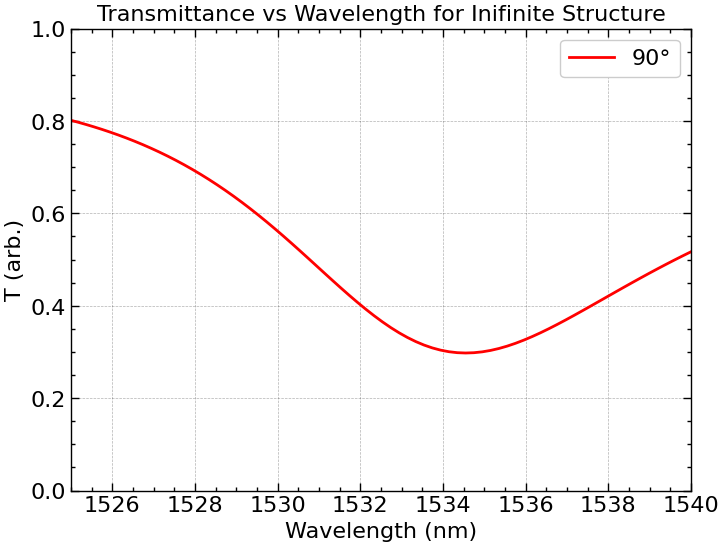

In [20]:
import scienceplots
# this uses scienceplots to make plots look better
plt.style.use(['science', 'notebook', 'grid'])

R = sim_infinite["R"].flux
T = -sim_infinite["T"].flux  # if you really want the negative

# convert freq→wavelength (µm)
wavelengths_um = (td.C_0 / T.f.values)
Tvals = T.values

# sort so wavelength increases left→right
idx = np.argsort(wavelengths_um)
wavelengths_um = wavelengths_um[idx]
Tvals = Tvals[idx]

plt.plot(wavelengths_um * 1000, Tvals, color="red", label="90°")
plt.xlim(1525, 1540)           # <-- zoom window in µm
plt.xlabel("Wavelength (nm)")
plt.ylabel("T (arb.)")
plt.grid(True, alpha=0.3)
plt.title("Transmittance vs Wavelength for Inifinite Structure")
plt.ylim(0, 1)
plt.legend()
plt.show()

### Source and Monitors

In [22]:
# ============================================================
#                    SOURCES             
# ============================================================

#-----------------------------------<< Choosing the Wavelength >>-----------------------------------------------
lambda_sel_um = 1.5325
idx = int(np.argmin(np.abs(sim_params["wvls"] - lambda_sel_um)))
lambda_used_um = float(sim_params["wvls"][idx])
f_sel = float(sim_params["freqs"][idx])
print(f"Plotting field at λ ≈ {lambda_used_um:.4f} µm  (f ≈ {f_sel/1e12:.3f} THz)")

gaussian = td.GaussianBeam(
    size=(td.inf, td.inf, 0),
    source_time=td.GaussianPulse(freq0=f_sel, fwidth=0.5 * sim_params["freqw"]),
    center=(px * (50 // 2), py * (50 // 2), lambda_used_um),
    direction="-",
    waist_radius=10* lambda_used_um,
)

Plotting field at λ ≈ 1.5325 µm  (f ≈ 195.618 THz)


In [23]:
# ============================================================
#                    MONITORS           
# ============================================================

#------------------------- << simulation domain size in z >>------------------------------
Lz = 3*lam2
#------------------------------ << Monitor z position >>----------------------------------
monitor_z =Lz/2.5
#----------------------- << Define Transmission Flux Monitor>>----------------------------
T_Monitor = td.FluxMonitor(
    center=[0, 0, -monitor_z], size=[td.inf, td.inf, 0], freqs=sim_params["freqs"], name="T"
)
#---------------- << Define Reflection Flux Monitor: Can be Changed >>--------------------
R_Monitor = td.FluxMonitor(
    center=[0, 0, monitor_z], size=[td.inf, td.inf, 0], freqs=sim_params["freqs"], name="R"
)   

# define a field monitor to visualize the field distribution under gaussian beam excitation
monitor_field = td.FieldMonitor(
    center=[0, 0, h/2], size=[td.inf, td.inf, 0], freqs=[f_sel], name="field"
)

## Simulation

In [ ]:
sim_actual = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, dioxide, atom],
    sources=[source],
    monitors=[T_Monitor,R_Monitor,monitor_field],
    run_time=sim_params["run_time"],
    boundary_spec=bc
)

In [21]:
# ============================================================
#                    FINITE METASURFACE              
# ============================================================
Nx = 50     # Number of Meta-Atoms in the x direction
Ny = 50     # Number of Meta-Atoms in the y direction

metasurface = [substrate]

for i in range(Nx):
    for j in range(Ny):
        # Shift positions
        x_shift = i * px
        y_shift = j * py

        # Silicon base (main disk)
        disk = td.Structure(
            geometry=td.PolySlab(
                vertices=[(x + x_shift, y + y_shift) for x, y in Meta_atom(0, 0, R, n)],
                axis=2,
                slab_bounds=(0, h),
            ),
            medium=silicon,
        )

        # Air hole
        hole = td.Structure(
            geometry=td.PolySlab(
                vertices=[(x + x_shift, y + y_shift) for x, y in Meta_atom(0, delta, rh, n)],
                axis=2,
                slab_bounds=(0, h),
            ),
            medium=Air,
        )

        metasurface.extend([disk, hole])

In [24]:
#-----------------------------<< Buffer Spacing in the x and y Directions >>------------------------------------
buffer = 2 * lambda_used_um
#-----------------------------------<< Simulation Domain Size >>-----------------------------------------------
Lx, Ly, Lz = Nx*px+2*buffer,Ny*py+2 * buffer, 3 * lambda_used_um
sim_size = [Lx, Ly, Lz]

sim = td.Simulation(
    size=sim_size,
    center=(px * (Nx // 2), py * (Ny // 2), 0),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=sim_params["Mesh"], wavelength= lambda_used_um),
    structures=metasurface,
    sources=[gaussian],
    monitors=[T_Monitor,R_Monitor,monitor_field],  # we will reuse the flux monitors defined earlier
    run_time=sim_params["run_time"],
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),  # pml is applied in all boundaries
    symmetry=(0, 0, 0),
)

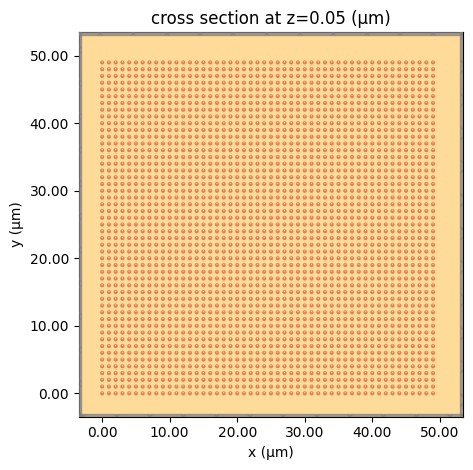

In [27]:
sim.plot(z=h/2)
plt.show()

In [26]:
sim_data = web.run(
    sim,
    task_name="Finite_Metasurface50",
    path="data/Finite_Metasurface50.hdf5",
    verbose=True,
)

15:32:19 EDT WARNING: Simulation has 2.42e+06 time steps. The 'run_time' may be 
             unnecessarily large, unless there are very long-lived resonances.  

             ERROR: Estimated internal storage of monitor 'T' is 51.55GB, which 
             is larger than the maximum allowed 50.00GB. Consider making it     
             smaller, using fewer frequencies, or spatial or temporal           
             downsampling using 'interval_space' and 'interval', respectively.  

SetupError: Estimated internal storage of monitor 'T' is 51.55GB, which is larger than the maximum allowed 50.00GB. Consider making it smaller, using fewer frequencies, or spatial or temporal downsampling using 'interval_space' and 'interval', respectively.